The is the example of GGF (Gibbs Gaussian Filter)

In [9]:
import matplotlib.pyplot as plt
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import KalmanFilter as KF
from filterpy.kalman import MerweScaledSigmaPoints, JulierSigmaPoints
from filterpy.kalman import unscented_transform
import autograd.numpy as np
from autograd import jacobian, hessian
import seaborn as sns
import types
import logging
import warnings
import time
# logging.basicConfig(level=logging.DEBUG)
from scipy.optimize import minimize


Define the dynamical model
$$
\begin{aligned}
x_{t+1} &= \begin{bmatrix} 1 & 0 & dt & 0 \\ 0 & 1 & 0 & dt \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1\end{bmatrix} x_t,
\\
y_t &= \begin{bmatrix}\sqrt{{x_t^{(0)}}^{2} + {x_t^{(1)}}^2} \\ \mathrm{arctan}\left(x^{(1)}_t / x^{(0)}_t \right) \end{bmatrix},
\\
\xi_t &\sim \mathcal{N}(0, 0.1^2 \mathbb{I}_{4 \times 4}), 
\\
\zeta_t &\sim \mathcal{N}(0, 0.1^2 \mathbb{I}_{2 \times 2}).
\end{aligned}
$$
The jacobian matrix of the function h is defined as
$$
J_h = \begin{bmatrix}
\frac{x_t^{(0)}}{\sqrt{{x_t^{(0)}}^2 + {x_t^{(1)}}^2}} & \frac{x_t^{(1)}}{\sqrt{{x_t^{(0)}}^2 + {x_t^{(1)}}^2}} \\
-\frac{x_t^{(1)}}{{x_t^{(0)}}^2 + {x_t^{(1)}}^2} & \frac{x_t^{(0)}}{{x_t^{(0)}}^2 + {x_t^{(1)}}^2}
\end{bmatrix}.
$$
Also, the explicit form of the loss function $\ell(x_t, y_t)$ is defined by the measurement model and the type of the loss. 

(1). If we choose the loss function as the negation of the log-likelihood, we have
$$
\ell(x_t, y_t) = \frac{1}{2}\|y_t - h(x_t)\|^2_{R^{-1}}.
$$
Then, its 1 st derivative (transpose of the Jacobian matrix) is defined as
$$
\frac{\partial \ell}{\partial x_t} = - \frac{\partial h}{\partial x_t} R^{-1} (y_t - h(x_t)) = - J_h^{\top} R^{-1} (y_t - h(x_t)).
$$
And it Hessian matrix is defined as
$$
\frac{\partial^2 \ell}{\partial x_t^2} =  \left(\frac{\partial h}{\partial x_t}\right)^{\top} R^{-1} \frac{\partial h}{\partial x_t} - (y_t - h(x_t))^{\top} R^{-1} \frac{\partial^2 h}{\partial x_t^2}.
$$

(2). If we choose the loss function as the weighted log-likelihood, we have
$$
\ell(x_t, y_t) = \frac{1}{2}\|y_t - h(x_t)\|^2_{R^{-1}} \cdot w(x_t, y_t),
$$
where $w(x_t, y_t):= 1+ \frac{1}{c^2} \cdot \left \|y_t-h(x_t)\right\|_{R_t^{-1}}^2$ is the weighting function.

For a general function, write an analytical form of all the jacobian and hessian matrices can be difficult. To tackle this, we can leverage the python package autograd....



In [4]:
class Model:
    dim_x = 4
    dim_y = 2
    x0 = np.array([0, 0, 1, 1])
    P0 = np.eye(dim_x)
    
    @classmethod
    def class_info(cls):
        class_vars = {k: v for k, v in cls.__dict__.items() if not callable(v) and not k.startswith("__")}
        return '\n'.join(f"Class {key} = {value}" for key, value in class_vars.items())

    
    def __init__(self, dt):
        self.dt = dt
        self.x = self.x0 + np.random.multivariate_normal(np.zeros_like(self.x0), self.P0)
        self.Q = np.diag([dt, dt, dt, dt]) ** 2
        self.R = np.diag([dt, dt]) ** 2
        
    def __str__(self):
        variables = vars(self)
        return '\n'.join(f"{key} = {value}" for key, value in variables.items())
    
    @staticmethod
    def f(x, dt):
        return [x[0] + x[2] * dt, x[1] + x[3] * dt, x[2], x[3]]

    @staticmethod
    def h(x):
        r = np.sqrt(x[0] ** 2 + x[1] ** 2)
        theta = np.arctan2(x[1], x[0])
        return [r, theta]
    
    # @staticmethod
    # def h(x):
    #     return [x[0], x[1]]
    
    # def h_jac(x):
    #     return np.array([[x[0] / np.sqrt(x[0] ** 2 + x[1] ** 2), x[1] / np.sqrt(x[0] ** 2 + x[1] ** 2)], [-x[1] / (x[0] ** 2 + x[1] ** 2), x[0] / (x[0] ** 2 + x[1] ** 2)]])

    # def h_jac(self, x):
    #     return jacobian(self.h)(x)
    
    def roll_out(self, step=1):
        for _ in range(step):
            self.x = self.f(self.x, self.dt)
    
    def observe(self):
        return self.h(self.x) + np.random.multivariate_normal(np.zeros(self.dim_y), self.R)
    
    @staticmethod
    def observe_wo_noise(x):
        return Model.h(x)

Then we create an instance of the model and save all the noisy measurements. Also, we plot the trajectories.

Class Info:  Class dim_x = 4
Class dim_y = 2
Class x0 = [0 0 1 1]
Class P0 = [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Class class_info = <classmethod object at 0x7f84fef5b190>
Class f = <staticmethod object at 0x7f84fef5b1f0>
Class h = <staticmethod object at 0x7f84cb56b520>
Class observe_wo_noise = <staticmethod object at 0x7f84c93a4880>


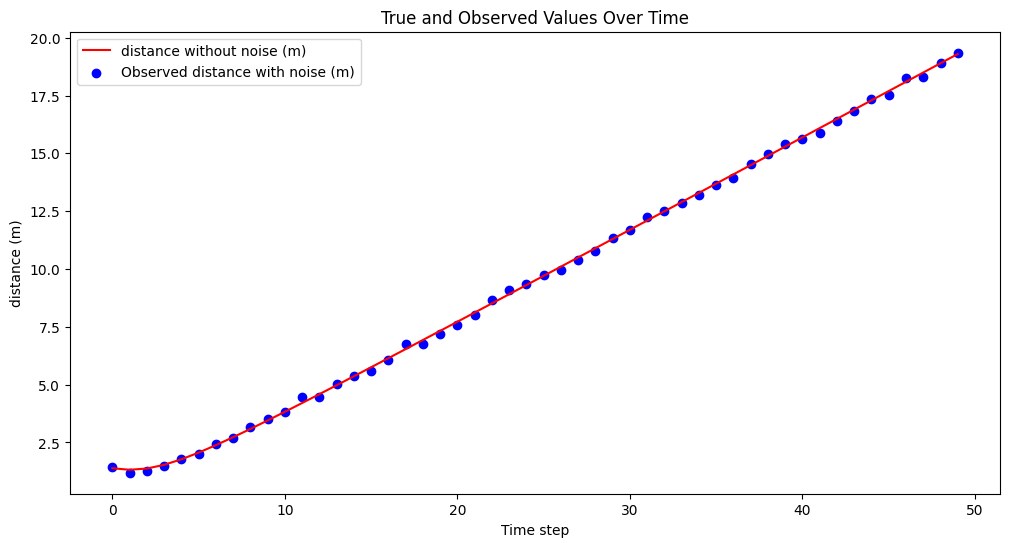

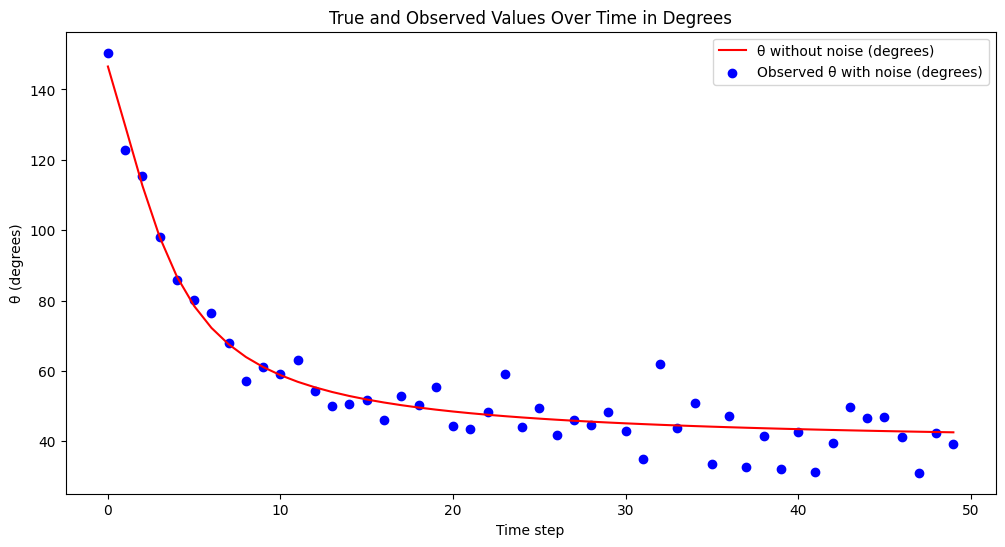

In [5]:
print('Class Info: ', Model.class_info())

n_mc = 2  # number of monte carlo runs
n_step = 50  # number of steps per experiment

x_mc = np.zeros((n_mc, n_step, Model.dim_x))
y_mc = np.zeros((n_mc, n_step, Model.dim_y))
y_mc_wo_noise = np.zeros((n_mc, n_step, Model.dim_y))

for i in range(n_mc):
    model = Model(0.1)
    for j in range(n_step):
        x_mc[i, j, :] = model.x
        y_mc[i, j, :] = model.observe()
        y_mc_wo_noise[i, j, :] = model.observe_wo_noise(model.x)
        model.roll_out()

# Selecting a single instance to plot
sample = np.random.randint(n_mc)
x_instance = x_mc[sample]
y_instance = y_mc[sample]
y_instance_wo_noise = y_mc_wo_noise[sample]

# Plotting the true state and observed values for one instance
plt.figure(figsize=(12, 6))
plt.plot(y_instance_wo_noise[:, 0], 'r-', label='distance without noise (m)')
plt.scatter(range(n_step), y_instance[:, 0], color='blue', label='Observed distance with noise (m)')
plt.xlabel('Time step')
plt.ylabel('distance (m)')
plt.title('True and Observed Values Over Time')
plt.legend()
plt.show()

y_obs_wo_noise_deg = np.degrees(y_instance_wo_noise[:, 1])
y_obs_noise_deg = np.degrees(y_instance[:, 1])

plt.figure(figsize=(12, 6))
plt.plot(y_obs_wo_noise_deg, 'r-', label='θ without noise (degrees)')
plt.scatter(range(n_step), y_obs_noise_deg, color='blue', label='Observed θ with noise (degrees)')
plt.xlabel('Time step')
plt.ylabel('θ (degrees)')
plt.title('True and Observed Values Over Time in Degrees')
plt.legend()
plt.show()

One challenge is to calculate the mean/expectation term. Luckily, we can use the so-called unscented transform to approximate it. The following function calculates the mean and var of a function under a symmetric Gaussian distribution. As this function will be widely used for the filter design, we also create an example to verify its correctness.

In [6]:
def is_positive_semidefinite(matrix):
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError('Matrix is not square')
    
    eigenvalues = np.linalg.eigvals(matrix)
    
    if np.any(eigenvalues < 0):
        print('Eigenvalues: ', eigenvalues)
        warnings.warn('Matrix is not positive semidefinite')
        
            
def cal_mean(func, mean, var, points):
    sigmas = points.sigma_points(mean, var)
    first_eval = func(sigmas[0])

    print('sigmas shape:', sigmas.shape)
    
    if isinstance(first_eval, np.ndarray):
        sigmas_func = np.zeros((sigmas.shape[0], *first_eval.shape))
    else:
        sigmas_func = np.zeros(sigmas.shape[0])
    
    print('sigmas_func shape:', sigmas_func.shape)
    
    for i, s in enumerate(sigmas):
        print('Point: ', i)
        print('State: ', s)
        sigmas_func[i] = func(s)
        print(f'sigmas_func {i}', sigmas_func[i])

        # if isinstance(sigmas_func[i], np.ndarray) and sigmas_func[i].ndim == 2:
        #     is_positive_semidefinite(sigmas_func[i])
    
    mean_func = np.tensordot(points.Wm, sigmas_func, axes=([0], [0]))
    return mean_func

# def moments(x):
#     x = x[0]
#     return np.array([[x, np.abs(x) ** 0.5], [x**2, np.abs(x) ** 1.5]])

# mean_fun = cal_mean(moments, 0, 1, MerweScaledSigmaPoints(1, alpha=1, beta=2, kappa=0))
# print('mean_fun: ', mean_fun)

# def moments(x):
#     return np.block([[x, np.abs(x) ** 0.5], [x**2, np.abs(x) ** 1.5]])

# mean_fun = cal_mean(moments, np.array([2, 1]), np.eye(2), MerweScaledSigmaPoints(2, alpha=1, beta=2, kappa=0))
# print('mean_fun: ', mean_fun)


Define the GGF class

Predict: UKF

Update: Natural Policy Gradient
$$
\begin{aligned}
\left( P_t^{-1} \right)^{(i+1)} =& \left( P_t^{-1} \right)^{(i)} -2 \left( P_t^{-1} \right)^{(i)}  
\left. \frac{\partial}{\partial P_t^{-1}} J(\hat{x}_t, P_t) \right|_{v^{(i)}} 
\left( P_t^{-1} \right)^{(i)},\\
\hat{x}^{(i+1)}_t =& \hat{x}^{(i)}_t - P_t^{(i+1)} 
\left.
\frac{\partial}{\partial \hat{x}_t} J(\hat{x}_t, P_t) \right|_{v^{(i)}}.
\end{aligned} 
$$
which equals
$$
\begin{aligned}
\left( P_t^{-1} \right)^{(i+1)} =& P_{t|t-1}^{-1}  + \mathbb{E}_{\mathcal{N}(x_t; \hat{x}_t^{(i)}, P_t^{(i)})} \left\{ \frac{\partial^2 \ell(x_t, y_t)}{\partial x_t^{\top} x_t} \right\},
\\
\hat{x}^{(i+1)}_t =& \hat{x}^{(i)}_t - P_t^{(i+1)} 
\mathbb{E}_{\mathcal{N}(x_t; \hat{x}_t^{(i)}, P_t^{(i)})} \left\{ \frac{\partial \ell(x_t, y_t)}{\partial x_t} \right\} -
P_t^{(i+1)} P_{t|t-1}^{-1}(\hat{x}_t^{(i)} - \hat{x}_{t|t-1}).
\end{aligned} 
$$

In [10]:
class GGF:
    def __init__(self, model):    
        self.model = model    
        self.x_hat = model.x0
        self.P = model.P0

        self.n_iterations = 10
        self.points = JulierSigmaPoints(n=model.dim_x)
        self.UT  = unscented_transform
        
    def log_likelihood_loss(self, x, y):
        return 0.5 * np.dot(y - self.model.h(x), np.dot(np.linalg.inv(self.model.R), y - self.model.h(x)))
    
    def log_likelihood_jacobian(self, x, y):
        # cal jacobian of loss function
        return jacobian(lambda x: self.log_likelihood_loss(x, y))(x)
        
    def log_likelihood_hessian(self, x, y):
        # cal hessian of loss function
        return hessian(lambda x: self.log_likelihood_loss(x, y))(x)
    
    def predict(self):
        print('----------predict----------')

        sigmas = self.points.sigma_points(self.x_hat, self.P)

        self.sigmas_f = np.zeros((len(sigmas), self.model.dim_x))
        for i, s in enumerate(sigmas):
            self.sigmas_f[i] = self.model.f(s, self.model.dt)        
        
        self.x_hat, self.P = self.UT(self.sigmas_f, self.points.Wm, self.points.Wc, self.model.Q)
        
        print('x_hat: ', self.x_hat)
        print('P: ', self.P)
    
    def map_loss(self, x_prior, P_prior, x_posterior, y):
        l1 = 0.5 * (x_posterior - x_prior).T @ np.linalg.inv(P_prior) @ (x_posterior - x_prior) 
        l2 = self.log_likelihood_loss(x_posterior, y)
        return l1 + l2
            
    def update_init(self, y, x_prior, P_prior):
        # Laplace近似
        loss = lambda x_posterior: self.map_loss(x_prior, P_prior, x_posterior, y)
        x_hat_posterior = minimize(loss, x0=x_prior, method='BFGS').x
        # print('----------update_init----------')
        # print('x_hat_posterior: ', x_hat_posterior)
        P_posterior_inv = hessian(lambda x: self.map_loss(x_prior, P_prior, x, y))(x_hat_posterior)
        # print('P_posterior_inv: ', P_posterior_inv)
        
        return x_hat_posterior, P_posterior_inv
    
    def update(self, y, n_iterations = None):
        print('----------update----------')
        
        if n_iterations is None:
            n_iterations = self.n_iterations
        
        # 求初始迭代步的Laplace近似后验估计
        x_hat_prior = self.x_hat.copy()
        P_inv_prior = np.linalg.inv(self.P).copy()
        time1 = time.time()
        x_hat, P_inv = self.update_init(y, x_hat_prior, self.P.copy())
        print('x_hat_init: ', x_hat)
        print('P_inv_init: ', P_inv)
        time2 = time.time()
        
        # perform natural gradient descent
        for _ in range(n_iterations):
            print('iteration: ', _)
            print('x_hat: ', x_hat)            
            P = np.linalg.inv(P_inv)
            is_positive_semidefinite(P)

            P_inv_next = P_inv_prior + cal_mean(lambda x: self.log_likelihood_hessian(x, y), x_hat, np.linalg.inv(P_inv), self.points)
            print('P_inv: ', P_inv)
            print('P:', np.linalg.inv(P_inv))
            # is_positive_semidefinite(P_inv)
            # is_positive_semidefinite(np.linalg.inv(P_inv))
            P_next = np.linalg.inv(P_inv_next)

            x_hat_next = x_hat - P_next @ cal_mean(lambda x: self.log_likelihood_jacobian(x, y), x_hat, P, self.points) - P_next @ P_inv_prior @ (x_hat - x_hat_prior)

            P_inv = P_inv_next.copy()
            x_hat = x_hat_next.copy()
        time3 = time.time()

        print('init time: ', time2 - time1)
        print('iterative time: ', time3 - time2)
            
        self.x_hat = x_hat
        self.P = np.linalg.inv(P_inv)

First, we test the correctness of the Hessian matrix.

In [11]:
ggf = GGF(Model(0.1))
hessian_value = ggf.log_likelihood_hessian(x=np.array([100, 0.11, -1, 9999]), y=np.ones(2))
print('Hessian: ', hessian_value)
H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
hessian_value = H.T @ np.linalg.inv(ggf.model.R) @ H
print('Hessian: ', hessian_value)

Hessian:  [[9.99999768e+01 1.10779618e-02 0.00000000e+00 0.00000000e+00]
 [1.10779618e-02 9.90100238e+01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Hessian:  [[100.   0.   0.   0.]
 [  0. 100.   0.   0.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]]


Then we perform the filtering procedure.

In [12]:
model = Model(0.1)
x_hat_mc = np.zeros((n_mc, n_step, Model.dim_x))
x_hat_ukf_mc = np.zeros((n_mc, n_step, Model.dim_x))
error_mc = np.zeros((n_mc, n_step, Model.dim_x))
error_ukf_mc = np.zeros((n_mc, n_step, Model.dim_x))
error_y_mc = np.zeros((n_mc, n_step, Model.dim_y))

for i in range(n_mc):
    ggf = GGF(model=model)
    ukf = UKF(dim_x=Model.dim_x, dim_z=Model.dim_y, dt=model.dt, fx=model.f, hx=model.h, points=JulierSigmaPoints(n=Model.dim_x))
    ukf.Q = model.Q
    ukf.R = model.R
    ukf.x = model.x0
    ukf.P = model.P0
    # kf = KF(dim_x=Model.dim_x, dim_z=Model.dim_y)
    # kf.x = model.x0
    # kf.P = model.P0
    # kf.F = np.array([[1, 0, model.dt, 0], [0, 1, 0, model.dt], [0, 0, 1, 0], [0, 0, 0, 1]])
    # kf.H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
    # kf.Q = model.Q
    # kf.R = model.R
    
    for j in range(n_step):
        x_hat_mc[i, j] = ggf.x_hat
        x_hat_ukf_mc[i, j] = ukf.x
        
        error_y_mc[i, j] = y_mc[i, j] - model.observe_wo_noise(x_mc[i, j])
        error_mc[i, j] = x_mc[i, j] - x_hat_mc[i, j]
        error_ukf_mc[i, j] = x_mc[i, j] - x_hat_ukf_mc[i, j]
        ggf.predict()
        ggf.update(y_mc[i, j])         
        ukf.predict()
        ukf.update(y_mc[i, j])
        # kf.predict()
        # kf.update(y_mc[i, j])

----------predict----------
x_hat:  [0.1 0.1 1.  1. ]
P:  [[1.02000000e+00 1.20370622e-33 1.00000000e-01 0.00000000e+00]
 [1.20370622e-33 1.02000000e+00 0.00000000e+00 1.00000000e-01]
 [1.00000000e-01 0.00000000e+00 1.01000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e-01 0.00000000e+00 1.01000000e+00]]
----------update----------
x_hat_init:  [-1.24155844  0.70716833  0.86847467  1.0595263 ]
P_inv_init:  [[ 8.83270593e+01 -2.23256052e+01 -9.80199961e-02  1.16807637e-34]
 [-2.23256052e+01  6.16291752e+01  1.16807637e-34 -9.80199961e-02]
 [-9.80199961e-02  1.16807637e-34  9.99803960e-01 -1.15651126e-35]
 [ 1.16807637e-34 -9.80199961e-02 -1.15651126e-35  9.99803960e-01]]
iteration:  0
x_hat:  [-1.24155844  0.70716833  0.86847467  1.0595263 ]
sigmas shape: (9, 4)
sigmas_func shape: (9, 4, 4)
Point:  0
State:  [-1.24155844  0.70716833  0.86847467  1.0595263 ]
sigmas_func 0 [[ 87.33705734 -22.32560524   0.           0.        ]
 [-22.32560524  60.63917325   0.           0.        ]
 [ 

/tmp/ipykernel_2464072/998893620.py:9: UserWarning: Matrix is not positive semidefinite
  warnings.warn('Matrix is not positive semidefinite')


LinAlgError: 2-th leading minor of the array is not positive definite

Then we analyze the filtering result. We calculate both the 

In [8]:
def calculate_rmse(error_mc):
    n_mc, n_step, dim_x = error_mc.shape

    squared_error_sum = np.sum(error_mc**2, axis=(1, 2))  # 在时间步和维度上求和

    rmse_per_experiment = np.sqrt(squared_error_sum / n_step)

    average_rmse = np.mean(rmse_per_experiment)

    return rmse_per_experiment, average_rmse

error_mc = calculate_rmse(error_mc)
error_ukf_mc = calculate_rmse(error_ukf_mc)

print('error_mc rmse: ', error_mc)
print('error_kf_mc rmse: ', error_ukf_mc)

error_mc rmse:  (array([0.57808956, 0.38638087]), 0.4822352157436641)
error_kf_mc rmse:  (array([0.59709201, 0.45772897]), 0.5274104905562508)


In [3]:
np.random.multivariate_normal(mean=np.zeros(2), cov=np.diag([1e-4, 1e-4])).astype(np.float32)

array([ 0.00289828, -0.01517076], dtype=float32)

In [5]:
import numpy as np
from scipy.linalg import sqrtm
A = np.array([[6, 3], 
              [3, 2]])
L = np.linalg.cholesky(A)

array([[2.44948974, 0.        ],
       [1.22474487, 0.70710678]])